In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-05-03 09:11:27--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 172.217.218.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-05-03 09:11:27 (118 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



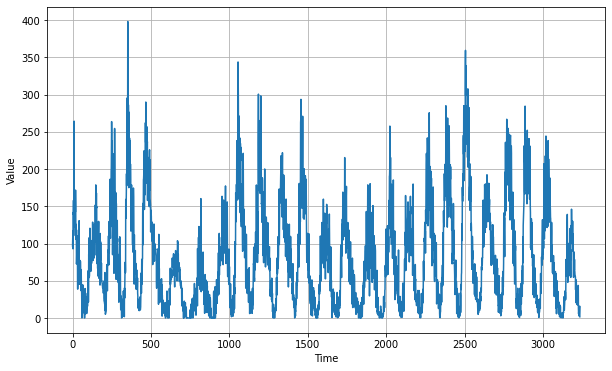

In [5]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

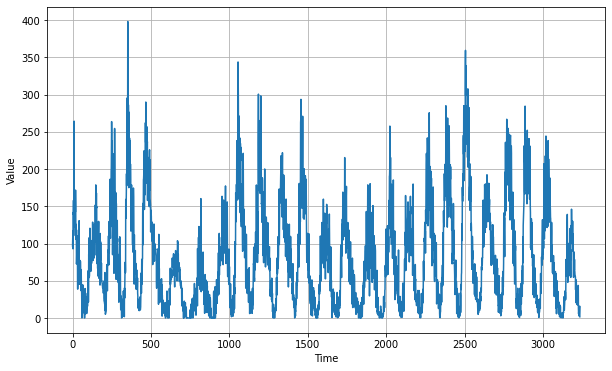

In [6]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 32s 27ms/step - loss: 77.0308 - mae: 77.5277
Epoch 2/100
12/12 [==============================] - 0s 26ms/step - loss: 75.8295 - mae: 76.3264
Epoch 3/100
12/12 [==============================] - 0s 26ms/step - loss: 73.8409 - mae: 74.3386
Epoch 4/100
12/12 [==============================] - 0s 28ms/step - loss: 70.0323 - mae: 70.5301
Epoch 5/100
12/12 [==============================] - 0s 27ms/step - loss: 66.1753 - mae: 66.6732
Epoch 6/100
12/12 [==============================] - 0s 26ms/step - loss: 62.9767 - mae: 63.4740
Epoch 7/100
12/12 [==============================] - 0s 27ms/step - loss: 59.8144 - mae: 60.3113
Epoch 8/100
12/12 [==============================] - 0s 26ms/step - loss: 56.0738 - mae: 56.5700
Epoch 9/100
12/12 [==============================] - 0s 27ms/step - loss: 52.7464 - mae: 53.2425
Epoch 10/100
12/12 [====

(1e-08, 0.0001, 0.0, 60.0)

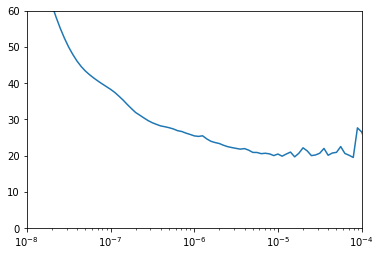

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 3s 14ms/step - loss: 47.7134 - mae: 48.2106
Epoch 2/500
30/30 [==============================] - 1s 15ms/step - loss: 26.8675 - mae: 27.3624
Epoch 3/500
30/30 [==============================] - 1s 15ms/step - loss: 22.9759 - mae: 23.4704
Epoch 4/500
30/30 [==============================] - 1s 14ms/step - loss: 20.2679 - mae: 20.7611
Epoch 5/500
30/30 [==============================] - 1s 15ms/step - loss: 19.3851 - mae: 19.8776
Epoch 6/500
30/30 [==============================] - 1s 14ms/step - loss: 19.3630 - mae: 19.8552
Epoch 7/500
30/30 [==============================] - 1s 15ms/step - loss: 18.5401 - mae: 19.0317
Epoch 8/500
30/30 [==============================] - 1s 14ms/step - loss: 17.9635 - mae: 18.4546
Epoch 9/500
30/30 [==============================] - 1s 15ms/step - loss: 17.9328 - mae: 18.4238
Epoch 10/500
30/30 [==============================] - 1s 15ms/step - loss: 19.7699 - mae: 20.2617
Epoch 11/500
30/30 [=========

In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

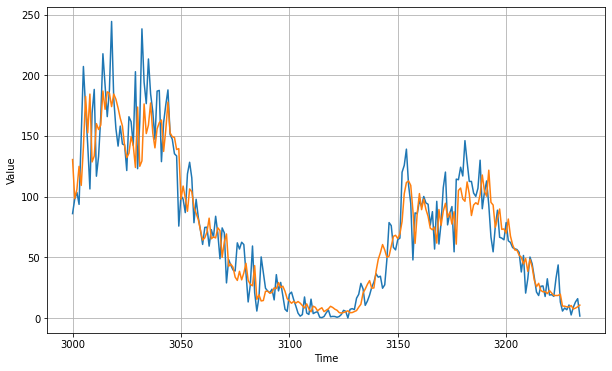

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.799844

<Figure size 432x288 with 0 Axes>

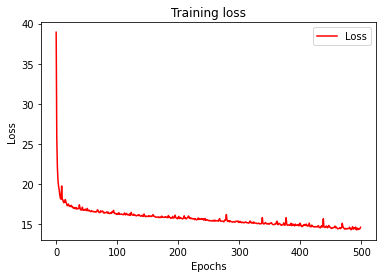

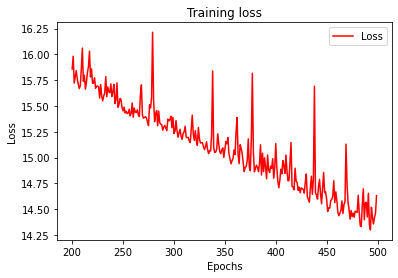

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [17]:
print(rnn_forecast)

[130.5121     98.3762    105.95224   124.92459   109.245255  140.65483
 182.52893   152.57323   184.46164   128.56165   133.4223    160.15285
 155.29234   158.92274   187.01158   171.9159    186.33337   185.20384
 174.15326   184.47554   180.17291   172.9728    164.52487   158.17612
 141.86461   132.11288   135.61943   149.49095   141.92245   124.00936
 173.78006   124.96726   129.44191   176.34306   151.93698   158.92691
 177.13658   152.39594   140.15329   155.92244   160.90224   163.09616
 137.2228    154.94638   177.88486   152.47058   149.3379    148.77153
 138.80792   139.54218    97.84265   108.68411    98.8655     87.90781
 106.311844  104.053856   91.58866    86.12785    81.18924    72.26481
  64.15377    66.01826    70.83534    82.24029    65.243095   66.79067
  65.95134    74.28948    71.97752    49.952023   62.559235   69.22522
  42.64792    44.397842   41.88646    33.677788   30.936665   38.426685
  31.422108   37.108772   45.0354     30.888456   27.711845   26.51274
  43.